## The goal is to prepare the data in our /videos with labels_dataframe.csv to make it ready for finetuning Faster-R CNN

we first take a look at how faster r-cnn finetune data is structered

In [5]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
import kagglehub
import cv2
import os
import matplotlib.pyplot as plt

we can go for the coco json annotation:
```dataset/
├── train/
│   ├── images/
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   └── annotations/
│       └── instances_train.json
├── val/
│   ├── images/
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   └── annotations/
│       └── instances_val.json

Sample COCO JSON annotation for one image:
{
    "images": [
        {"id": 1, "file_name": "image1.jpg", "height": 480, "width": 640},
        
    ],
    "annotations": [
        {"id": 1, "image_id": 1, "category_id": 1, "bbox": [100, 200, 50, 50], "area": 2500, "iscrowd": 0}
    ],
    "categories": [
        {"id": 1, "name": "object_class"}
    ]
}


or the Pascal VOC Format:
dataset/
├── train/
│   ├── images/
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   ├── annotations/
│       ├── image1.xml
│       ├── image2.xml

Sample XML annotation for one image:
<annotation>
    <folder>images</folder>
    <filename>image1.jpg</filename>
    <size>
        <width>640</width>
        <height>480</height>
    </size>
    <object>
        <name>object_class</name>
        <bndbox>
            <xmin>100</xmin>
            <ymin>200</ymin>
            <xmax>150</xmax>
            <ymax>250</ymax>
        </bndbox>
    </object>
</annotation>```


Right now the data looks like this:

In [6]:
df = pd.read_csv('data/labels_dataframe.csv')
df.head(20)

,Task ID,Task Name,Job Id,Source,Frames,Absolute Frame,Relative Frame,XTL,YTL,XBR,YBR,Code,Issue
0,138,Task1,133,1690279852.mp4,730,54,54,29.87,506.88,190.69,554.96,83/2789,NaN
1,138,Task1,133,1690279852.mp4,730,55,55,65.26,504.87,225.50,552.95,83/2789,NaN
2,138,Task1,133,1690279852.mp4,730,56,56,131.98,503.67,291.63,551.76,83/2789,NaN
3,138,Task1,133,1690279852.mp4,730,57,57,198.69,502.48,357.76,550.57,83/2789,NaN
4,138,Task1,133,1690279852.mp4,730,58,58,241.62,498.68,400.10,546.77,83/2789,NaN
5,138,Task1,133,1690279852.mp4,730,59,59,302.70,496.68,460.59,544.77,83/2789,NaN
6,138,Task1,133,1690279852.mp4,730,60,60,363.79,494.68,521.09,542.78,83/2789,NaN
7,138,Task1,133,1690279852.mp4,730,61,61,424.87,492.68,581.58,540.78,83/2789,NaN
8,138,Task1,133,1690279852.mp4,730,62,62,485.95,490.69,642.08,538.78,83/2789,NaN
9,138,Task1,133,1690279852.mp4,730,63,63,547.03,488.69,702.57,536.78,83/2789,NaN


The columns we need for COCO are:

images:
- ID
- File name
- height/width of the picture

annotations:
- ID
- Image_id
- category ID
- bounding box (coordinates)
- area (oppervlakte van bounding box)
- iscrowd (used to indicate whether an object is part of a "crowd" or a group of objects that cannot be easily separated)

categories:
- ID
- Category class (string)

We have all of these classes we just need to format them, except for the file_name but we can get this by loading the video and then get the frame of that video and then get the video file addressed to this

### Let's see what we need to do in order to fine tune Faster R-CNN

In [7]:
# Load pre-trained Faster R-CNN model
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the classifier for custom classes
num_classes = 2  # 1 class + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Dataset and DataLoader
train_dataset = CocoDetection(root='dataset/train/images',
                              annFile='dataset/train/annotations/instances_train.json',
                              transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training Loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for epoch in range(10):
    model.train()
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch}, Loss: {losses.item()}")


c:\Users\ewald\.conda\envs\pygpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ewald\.conda\envs\pygpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ModuleNotFoundError: No module named 'pycocotools'

We already have some images on Kaggle:

In [8]:
path = kagglehub.dataset_download("stanislavlevendeev/hazmat-detection")


In [ ]:
path

'C:\\Users\\ewald\\.cache\\kagglehub\\datasets\\stanislavlevendeev\\hazmat-detection\\versions\\7'

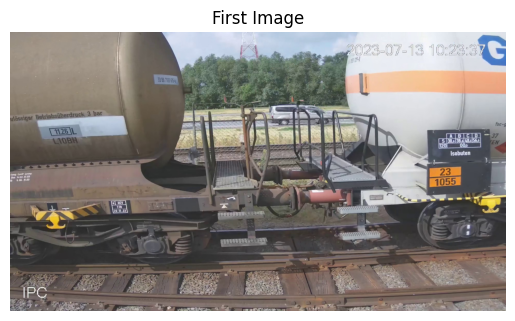

In [14]:
# Define the path to the folder containing images
images = path + "/yolo/frames"

# Get the first image in the folder
first_image_path = os.path.join(images, os.listdir(images)[0])

# Read the image using OpenCV
image = cv2.imread(first_image_path)

# Convert the image from BGR (OpenCV default) to RGB (for matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Hide the axis for better display
plt.title("First Image")
plt.show()

In [10]:
# print all the filenames in the folder
print(os.listdir(images))

['1690281365_00000.jpg', '1690281365_00001.jpg', '1690281365_00002.jpg', '1690281365_00003.jpg', '1690281365_00004.jpg', '1690281365_00005.jpg', '1690281365_00006.jpg', '1690281365_00007.jpg', '1690281365_00008.jpg', '1690281365_00009.jpg', '1690281365_00010.jpg', '1690281365_00011.jpg', '1690281365_00012.jpg', '1690281365_00013.jpg', '1690281365_00014.jpg', '1690281365_00015.jpg', '1690281365_00016.jpg', '1690281365_00017.jpg', '1690281365_00018.jpg', '1690281365_00019.jpg', '1690281365_00020.jpg', '1690281365_00021.jpg', '1690281365_00022.jpg', '1690281365_00023.jpg', '1690281365_00024.jpg', '1690281365_00025.jpg', '1690281365_00026.jpg', '1690281365_00027.jpg', '1690281365_00028.jpg', '1690281365_00029.jpg', '1690281365_00030.jpg', '1690281365_00031.jpg', '1690281365_00032.jpg', '1690281365_00033.jpg', '1690281365_00034.jpg', '1690281365_00035.jpg', '1690281365_00036.jpg', '1690281365_00037.jpg', '1690281365_00038.jpg', '1690281365_00039.jpg', '1690281365_00040.jpg', '1690281365_000

In [35]:
# this format is the video name + frame number so "123456789_000000.jpg" is the first frame of the video "123456789"
# we need to make this:
# images:
# - ID
# - File name
# - height/width of the picture
# example:
# "images": [
#     {"id": 1, "file_name": "image1.jpg", "height": 480, "width": 640}
# ],

# Create a list to store the image information
images_list = []

# Loop through all the files in the folder
for idx, filename in enumerate(os.listdir(images)):
    # Get the full path to the file
    file_path = os.path.join(images, filename)
    
    # Ensure the file is an image by checking its extension
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        # Read the image using OpenCV
        image = cv2.imread(file_path)
        
        # Check if the image was read successfully
        if image is not None:
            # Get the height and width of the image
            height, width, _ = image.shape
            
            # Append the image information to the list
            images_list.append({
                "id": idx + 1,  # Assign a unique ID starting from 1
                "file_name": filename,
                "height": height,
                "width": width
            })

# Display the first 5 images' metadata
images_list[:5]

[{'id': 1, 'file_name': '1690281365_00000.jpg', 'height': 1080, 'width': 1920},
 {'id': 2, 'file_name': '1690281365_00001.jpg', 'height': 1080, 'width': 1920},
 {'id': 3, 'file_name': '1690281365_00002.jpg', 'height': 1080, 'width': 1920},
 {'id': 4, 'file_name': '1690281365_00003.jpg', 'height': 1080, 'width': 1920},
 {'id': 5, 'file_name': '1690281365_00004.jpg', 'height': 1080, 'width': 1920}]

In [16]:
# now we need to get the annotations from the dataframe
# annotation have to be in this format:
# "annotations": [
#     {"id": 1, "image_id": 1, "category_id": 1, "bbox": [100, 200, 50, 50], "area": 2500, "iscrowd": 0}
# ],
# we need to get the image id by seeing which frame and video is in the row

df.head()

,Task ID,Task Name,Job Id,Source,Frames,Absolute Frame,Relative Frame,XTL,YTL,XBR,YBR,Code,Issue
0,138,Task1,133,1690279852.mp4,730,54,54,29.87,506.88,190.69,554.96,83/2789,NaN
1,138,Task1,133,1690279852.mp4,730,55,55,65.26,504.87,225.50,552.95,83/2789,NaN
2,138,Task1,133,1690279852.mp4,730,56,56,131.98,503.67,291.63,551.76,83/2789,NaN
3,138,Task1,133,1690279852.mp4,730,57,57,198.69,502.48,357.76,550.57,83/2789,NaN
4,138,Task1,133,1690279852.mp4,730,58,58,241.62,498.68,400.10,546.77,83/2789,NaN


In [18]:
# we need the datasets for this instance where source == "1690281365.mp4"
df_instance = df[df["Source"] == "1690281365.mp4"]
df_instance.head()

,Task ID,Task Name,Job Id,Source,Frames,Absolute Frame,Relative Frame,XTL,YTL,XBR,YBR,Code,Issue
201,142,"{task2, task3}",138,1690281365.mp4,733,730,0,1623.22,519.1,1752.50,597.75,23/1055,NaN
202,142,"{task2, task3}",138,1690281365.mp4,733,731,1,1686.14,519.1,1815.41,597.75,23/1055,NaN
203,142,"{task2, task3}",138,1690281365.mp4,733,732,2,1712.35,515.6,1841.63,594.25,23/1055,NaN
204,142,"{task2, task3}",138,1690281365.mp4,733,733,3,1770.02,515.6,1899.29,594.25,23/1055,NaN
205,142,"{task2, task3}",138,1690281365.mp4,733,734,4,1770.02,515.6,1899.29,594.25,23/1055,NaN


In [36]:
# "annotations": [
#     {"id": 1, "image_id": 1, "category_id": 1, "bbox": [100, 200, 50, 50], "area": 2500, "iscrowd": 0}
# ],

# bbox is in the format [x, y, width, height]
# area is width * height

# we need to look at the "source + relative frame" column to get the frame for the image

# loop over images list
# get the id
# look in the dataframe for the bounding box by searching by "source + relative frame"
# get the bounding box
# calculate the area
# set category id to 1


# Create a list to store the annotations
annotations_list = []

id = 0
print(len(images_list))
# Loop through all the images
for image in images_list:
    image_id = image["id"]
    image_name = image["file_name"]

    # get the frame number from the image name
    frame_number = int(image_name.split("_")[-1].split(".")[0])
    # remove all 0's from the start of the frame number except if the frame number == 00000, then make it 0
    frame_number = str(frame_number).lstrip("0") if frame_number != 0 else "0"
    # get the video name from the image name
    video_name = image_name.split("_")[0]
    video_name = video_name+".mp4"

    # get the row from the dataframe
    row = df_instance[(df_instance["Source"] == video_name) & (df_instance["Relative Frame"] == int(frame_number))]
    # check if the row is not empty
    if row.empty == False or row["XTL"].values[0]:
        x_left_top = row["XTL"].values[0]
        y_left_top = row["YTL"].values[0]
        x_right_bottom = row["XBR"].values[0]
        y_right_bottom = row["YBR"].values[0]

        # get the bounding box
        width = x_right_bottom - x_left_top
        height = y_right_bottom - y_left_top
        # calculate the area
        area = width * height
        # make the bbox
        bbox = [x_left_top, y_left_top, width, height]

        # create the annotation
        id += 1

        annotation = {
            "id": id,
            "image_id": image_id,
            "category_id": 1,
            "bbox": bbox,
            "area": area,
            "iscrowd": 0
        }

        # Append the annotation to the list
        annotations_list.append(annotation)
    else:
        print(f"There are no hazamat codes in the image {image_name}")
        # remove the image from images_list
        images_list.remove(image)

print(f"removed images which contain no hazmat codes, {len(images_list)} images left")
# Display the first 5 annotations
annotations_list[:5]

733
There are no hazamat codes in the image 1690281365_00005.jpg
There are no hazamat codes in the image 1690281365_00007.jpg
There are no hazamat codes in the image 1690281365_00009.jpg
There are no hazamat codes in the image 1690281365_00011.jpg
There are no hazamat codes in the image 1690281365_00013.jpg
There are no hazamat codes in the image 1690281365_00015.jpg
There are no hazamat codes in the image 1690281365_00017.jpg
There are no hazamat codes in the image 1690281365_00019.jpg
There are no hazamat codes in the image 1690281365_00021.jpg
There are no hazamat codes in the image 1690281365_00023.jpg
There are no hazamat codes in the image 1690281365_00025.jpg
There are no hazamat codes in the image 1690281365_00027.jpg
There are no hazamat codes in the image 1690281365_00029.jpg
There are no hazamat codes in the image 1690281365_00031.jpg
There are no hazamat codes in the image 1690281365_00033.jpg
There are no hazamat codes in the image 1690281365_00035.jpg
There are no hazamat

[{'id': 1,
  'image_id': 1,
  'category_id': 1,
  'bbox': [1623.22, 519.1, 129.27999999999997, 78.64999999999998],
  'area': 10167.871999999996,
  'iscrowd': 0},
 {'id': 2,
  'image_id': 2,
  'category_id': 1,
  'bbox': [1686.14, 519.1, 129.26999999999998, 78.64999999999998],
  'area': 10167.085499999996,
  'iscrowd': 0},
 {'id': 3,
  'image_id': 3,
  'category_id': 1,
  'bbox': [1712.35, 515.6, 129.2800000000002, 78.64999999999998],
  'area': 10167.872000000012,
  'iscrowd': 0},
 {'id': 4,
  'image_id': 4,
  'category_id': 1,
  'bbox': [1770.02, 515.6, 129.26999999999998, 78.64999999999998],
  'area': 10167.085499999996,
  'iscrowd': 0},
 {'id': 5,
  'image_id': 5,
  'category_id': 1,
  'bbox': [1770.02, 515.6, 129.26999999999998, 78.64999999999998],
  'area': 10167.085499999996,
  'iscrowd': 0}]

In [42]:
# begin by getting the labels dataset from kaggle
path_l = path + "/labels_dataframe.csv"

# Load the labels dataset
df_labels = pd.read_csv(path_l)
df_labels.head()

,Task ID,Task Name,Job Id,Source,Frames,Absolute Frame,Relative Frame,XTL,YTL,XBR,YBR,Code,Issue
0,138,Task1,133,1690279852.mp4,730,54,54,29.87,506.88,190.69,554.96,83/2789,NaN
1,138,Task1,133,1690279852.mp4,730,55,55,65.26,504.87,225.50,552.95,83/2789,NaN
2,138,Task1,133,1690279852.mp4,730,56,56,131.98,503.67,291.63,551.76,83/2789,NaN
3,138,Task1,133,1690279852.mp4,730,57,57,198.69,502.48,357.76,550.57,83/2789,NaN
4,138,Task1,133,1690279852.mp4,730,58,58,241.62,498.68,400.10,546.77,83/2789,NaN


In [50]:
# loop over and check if it is in the images_list

# Create a list to store the annotations
annotations_list = []

id = 0
# loop over df_labels
for idx, row in df_labels.iterrows():
    # get the frame number from the row
    frame_number = row["Absolute Frame"]
    # get the image associated with the frame number but first check if the frame number is in the images_list
    for img in images_list:
        # Get the file name
        file_name = img["file_name"]
        # Get the last part of the filename after splitting to "_"
        file_parts = file_name.split("_")
        last_part = file_parts[-1]
        # Split the last part further at the point (".") and extract the first value
        frame_str = last_part.split(".")[0]
        frame_str = str(frame_str).lstrip("0") if frame_str != 0 else "0"
        # Compare the frame number with the value in the list
        if frame_str == str(frame_number):
            # print(f"Frame number {frame_number} found in the images list, image id is {img['id']}")
            x_left_top = row["XTL"]
            y_left_top = row["YTL"]
            x_right_bottom = row["XBR"]
            y_right_bottom = row["YBR"]
            # get the bounding box
            width = x_right_bottom - x_left_top
            height = y_right_bottom - y_left_top
            # calculate the area
            area = width * height
            # make the bbox
            bbox = [x_left_top, y_left_top, width, height]
            id += 1
            annotation = {
                "id": id,
                "image_id": img["id"],
                "category_id": 1,
                "bbox": bbox,
                "area": area,
                "iscrowd": 0
            }
            # Append the annotation to the list
            annotations_list.append(annotation)

# Display the first 5 annotations
annotations_list[:5]
   

[{'id': 1,
  'image_id': 55,
  'category_id': 1,
  'bbox': [29.87, 506.88, 160.82, 48.08000000000004],
  'area': 7732.225600000006,
  'iscrowd': 0},
 {'id': 2,
  'image_id': 56,
  'category_id': 1,
  'bbox': [65.26, 504.87, 160.24, 48.08000000000004],
  'area': 7704.339200000007,
  'iscrowd': 0},
 {'id': 3,
  'image_id': 57,
  'category_id': 1,
  'bbox': [131.98, 503.67, 159.65, 48.089999999999975],
  'area': 7677.568499999997,
  'iscrowd': 0},
 {'id': 4,
  'image_id': 58,
  'category_id': 1,
  'bbox': [198.69, 502.48, 159.07, 48.09000000000003],
  'area': 7649.676300000005,
  'iscrowd': 0},
 {'id': 5,
  'image_id': 59,
  'category_id': 1,
  'bbox': [241.62, 498.68, 158.48000000000002, 48.089999999999975],
  'area': 7621.303199999997,
  'iscrowd': 0}]

In [37]:
print(len(images_list))
print(len(annotations_list))

464
196


In [40]:
# find where XLT is None
df_instance[ df_instance["XTL"] == 0]

,Task ID,Task Name,Job Id,Source,Frames,Absolute Frame,Relative Frame,XTL,YTL,XBR,YBR,Code,Issue
206,142,"{task2, task3}",138,1690281365.mp4,733,781,51,0.0,447.50,139.53,501.63,83/1715,NaN
291,142,"{task2, task3}",138,1690281365.mp4,733,1230,500,0.0,564.54,139.53,641.44,23/1969,NaN


In [29]:
# now let's create the category list
# "categories": [
#     {"id": 1, "name": "object_class"}
# ]

categories_list = [
    {"id": 1, "name": "hazmat code"}
]

In [33]:
import json
# now we need to concat the images, annotations and categories into a dictionary
# example:
#{
#     "images": [
#         {"id": 1, "file_name": "image1.jpg", "height": 480, "width": 640}
#     ],
#     "annotations": [
#         {"id": 1, "image_id": 1, "category_id": 1, "bbox": [100, 200, 50, 50], "area": 2500, "iscrowd": 0}
#     ],
#     "categories": [
#         {"id": 1, "name": "object_class"}
#     ]
# }


# store the data in JSON file format for a train (80%), validation (10%) and test (10%) split
# we need to shuffle the images and then split them into 80% train, 10% validation and 10% test
import random
random.seed(42)
random.shuffle(images_list)
# get the 80% of the images
train_images = images_list[:int(len(images_list)*0.8)]
# get 10% of the images which are not in the train_images
validation_images = images_list[int(len(images_list)*0.8):int(len(images_list)*0.9)]
# get the rest of the images
test_images = images_list[int(len(images_list)*0.9):]

# check if there are no overlapping id's in train, validation and test
train_ids = [image["id"] for image in train_images]
validation_ids = [image["id"] for image in validation_images]
test_ids = [image["id"] for image in test_images]

for id in train_ids:
    if id in validation_ids or id in test_ids:
        print(f"Train ID {id} is in validation or test")

# get the corresponding annotations for the images
train_annotations = [annotation for annotation in annotations_list if annotation["image_id"] in train_ids]
validation_annotations = [annotation for annotation in annotations_list if annotation["image_id"] in validation_ids]
test_annotations = [annotation for annotation in annotations_list if annotation["image_id"] in test_ids]

# check if there are no overlapping id's in train, validation and test

for annotation in train_annotations:
    if annotation["image_id"] in validation_ids or annotation["image_id"] in test_ids:
        print(f"Train ID {annotation['image_id']} is in validation or test")

# Save the data to a JSON file for the train, test and validation split
data_train = {
    "images": train_images,
    "annotations": train_annotations,
    "categories": categories_list
}

data_validation = {
    "images": validation_images,
    "annotations": validation_annotations,
    "categories": categories_list
}

data_test = {
    "images": test_images,
    "annotations": test_annotations,
    "categories": categories_list
}

def save_json(data, json_path):
    with open(json_path, "w") as file:
        json.dump(data, file)

# Save the data to a JSON file
save_json(data_train, "data/train.json")
save_json(data_validation, "data/validation.json")
save_json(data_test, "data/test.json")

In [ ]:
# now let's use this data to create the CocoDetection dataset
# Dataset and DataLoader
train_dataset = CocoDetection(root='dataset/train/images',
                              annFile='dataset/train/annotations/instances_train.json',
                              transform=transforms.ToTensor())
